# Rozdzielczość obrazu. Interpolacja.

## Cel zajęć:

- zapoznanie z pojęciem rozdzielczości przestrzennej (rozmiaru obrazu),
- metody interpolacji najbliższego sąsiada oraz dwuliniowa,
- zapoznanie z pojęciem rozdzielczości dpi (ang. dots per inch),
- zapoznanie z pojęciem rozdzielczości poziomów jasności (dla obrazów w skali szarości),
- zadanie domowe: interpolacja dwusześcienna.

## Rodzielczość przestrzenna

Dyskretna reprezentacja obrazu to zwykle macierz dwu (N x M - obraz w skali szarości) lub trójwymiarowa (N x M x 3 - obraz kolorowy).
Przez rozdzielczość przestrzenną rozumie się liczbę pikseli z których składa się obraz.
Przykładowo rozdzielczość VGA to 640 x 480, FullHD to 1920 x 1080, a UltraHD (4K) to 3840 x 2160.
Rozdzielczość obrazu można modyfikować (zwiększać/zmniejszać), co nazywa się skalowaniem obrazu.
Warto wiedzieć, że zwiększenie rozdzielczości obrazu nie zwiększa ilości informacji, a jedynie liczbę pikseli (w sensie "lepiej nie będzie").
Ponadto skalowanie zawsze wprowadza pewne zniekształcenia, nawet przy zmniejszaniu rozmiaru.

W ramach niniejszego ćwiczenia zapoznamy się z metodami interpolacji, które są podstawą takich operacji jak: przybliżanie (zoom), zmiana rozdzielczości, rotacja obrazu, czy też korekcje geometryczne.
Jako przykład posłuży nam zmiana rozdzielczości, czyli inaczej mówiąc przepróbkowanie obrazu.
Dla przypomnienia - interpolacja to wykorzystanie znanych danych (wartości dla tzw. punktów węzłowych) do określania wartości w nieznanych lokalizacjach.

Zacznijmy od prostego przykładu.
Mamy obraz o rozdzielczości 500 x 500 pikseli, a chcemy go powiększyć do 750 x 750 pikseli -- tj. o współczynnik 1,5.
Wyobraźmy sobie zatem, że dysponujemy siatką 750 x 750 o takim samym "rozmiarze" pojedynczego piksela jak obraz oryginalny.
Następnie siatkę tą ,,ścieśniamy'', tak aby miała rozmiar 500 x 500.
W rezultacie otrzymana siatka będzie miała mniejszy rozmiar pojedynczego piksela niż obraz oryginalny.
Schematycznie przedstawiono to na poniższym rysunku.

![Ilustracja interpolacji](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interEx57.png)

Pokazuje on przykład interpolacji: a) obraz 5x5, b) oraz 7x7, c) obraz 7x7 zmiejszony do 5x5.

Chcemy teraz poszczególnym elementom nowej siatki przyporządkować piksele z obrazu wejściowego.
Jedną z możliwości jest poszukanie "najbliższego" piksela w oryginalnym obrazie i wzięcie jego wartości.
Przykład takiego postępowania zaprezentowano na poniższym rysunku.

![Ilustracja najbliższego sąsiada](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/inteNNEx.png)

Kilka słów wyjasnienia.
Kolorem ciemnoszarym oznaczono siatkę 5x5, a czarnym 7x7 (już po przeskalowaniu).
Nasze zadanie sprowadza się do znalezienia dla każdej kropki czarnej (umowny środek piksela), najbliżej leżącej kropki szarej - oznaczono to dla pierwszych trzech wierszy obrazu liniami.

Po zrealizowaniu powyższego kroku dla całego obrazu wykonujemy "rozciągniecie" do rozdzielczości 750 x 750.
W ten sposób uzyskujemy finalny efekt zmiany rozdzielczości.

## Interpolacja metodą najbliższego sąsiada

Takie postępowanie określa się mianem **interpolacji metodą najbliższego sąsiada** (ang. _nearest neighbour interpolation_).
W ramach pierwszego etapu ćwiczenia zaimplementujemy to podejście.

1. Ładujemy potrzebne biblioteki, pobieramy obrazy z repozytorium, wczytujemy jeden z obrazów testowych (_parrot.bmp_) i wyświetlamy go:


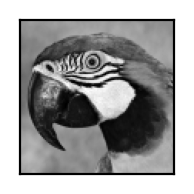

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/'

fileNames = ["parrot.bmp", "clock.bmp",
             "chessboard.bmp", "lena.bmp", "firetruck.jpg"]
for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, 'wb').write(r.content)


I = cv2.imread('parrot.bmp')           # Read image
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)  # Convert to RGB

# Display
plt.figure(figsize=(I.shape[0]/100, I.shape[1]/100), dpi=200)
plt.imshow(I, cmap="gray")
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

2. Definiujemy funkcję do interpolacji metodą najbliższego sąsiada.

Jako argumenty wejściowe powinna ona przyjąć obraz oraz współczynniki skalowania w pionie i poziomie.
Wyjściem powinien być natomiast obraz w nowej rozdzielczości.
Wewnątrz należy:

- odczytać wymiary obrazka wejściowego,
- wyliczyć wymiary obrazka wyjściowego (tj. wymnożyć wymiary wejściowe przez skalę i zaokrąglić do liczb całkowitych),
- utworzyć nowy obraz o ww. rozmiarze,
- w pętli po nowym obrazie, dla każdego piksela, wykorzystując współczynniki skalowania, odnaleźć najbliższego sąsiada.


In [2]:
def scale(img, x_scale, y_scale):
    x, y = img.shape
    xo = int(x*x_scale)
    yo = int(y*y_scale)
    scaled_img = np.zeros((xo, yo))

    def scaled_indices(i, j):
        i = round(i / x_scale)
        j = round(j / y_scale)
        return min(i, x-1), min(j, y-1)
    for i in range(xo):
        for j in range(yo):
            scaled_img[i, j] = img[scaled_indices(i, j)]
    return scaled_img

3. Testujemy stworzoną funkcję:
   - dla skali 1.5, 1.5 i obrazka _parrot_,
   - dla 2.5, 2.5 - tu może okazać się, że do kodu trzeba dopisać zabezpieczenie przed wyjściem poza zakres,
   - dla niejednakowych skal np. 1.5 i 2.5,
   - dla skal mniejszych od 1,
   - dla niesymetrycznego obrazka _clock_,
   - dla obrazka z szachownicą _chessboard_.

Uwaga: proszę dla powyższych przypadków przygotować osobne sekcje kodu - tak, aby wyświetlały się wszystkie rozważane przypadki.

Wykonana metoda jest bardzo prosta i szybka, ale wprowadza pewne niepożądane artefakty, w szczególnie źle odwzorowane są linie proste.
Z drugiej strony sprawdza się w pewnych nietypowych przypadkach.
Zostanie to zademonstrowane w dalszej części ćwiczenia.


In [3]:
parrot = cv2.imread('parrot.bmp', cv2.IMREAD_GRAYSCALE)

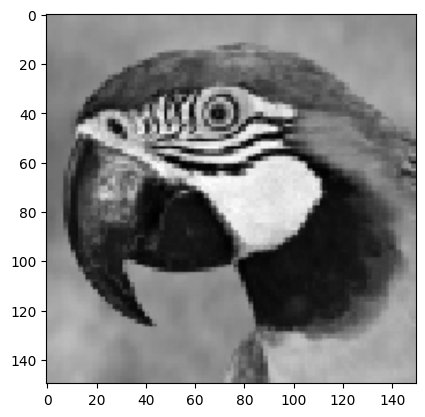

In [4]:
parrot_scaled = scale(parrot, 1.5, 1.5)
plt.imshow(parrot_scaled, 'gray')

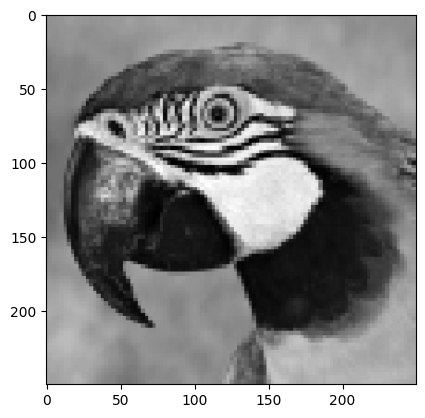

In [5]:
parrot_scaled = scale(parrot, 2.5, 2.5)
plt.imshow(parrot_scaled, 'gray')

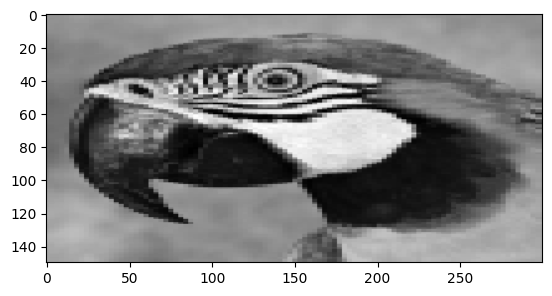

In [6]:
parrot_scaled = scale(parrot, 1.5, 3)
plt.imshow(parrot_scaled, 'gray')

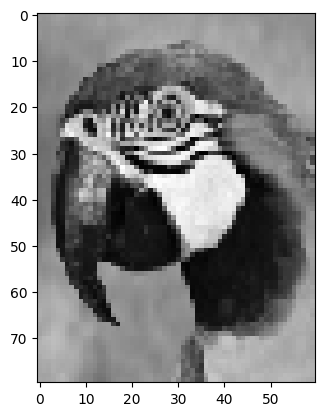

In [7]:
parrot_scaled = scale(parrot, 0.8, 0.6)
plt.imshow(parrot_scaled, 'gray')

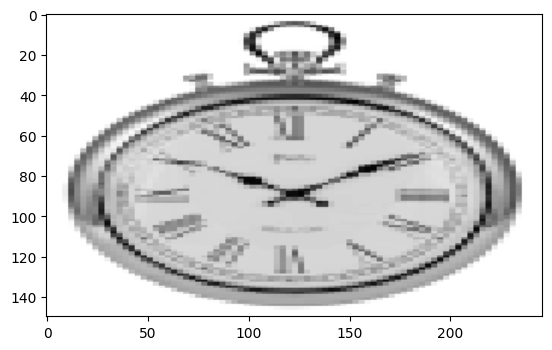

In [8]:
clock = cv2.imread('clock.bmp', cv2.IMREAD_GRAYSCALE)
clock_scaled = scale(clock, 1.5, 3)
plt.imshow(clock_scaled, 'gray')

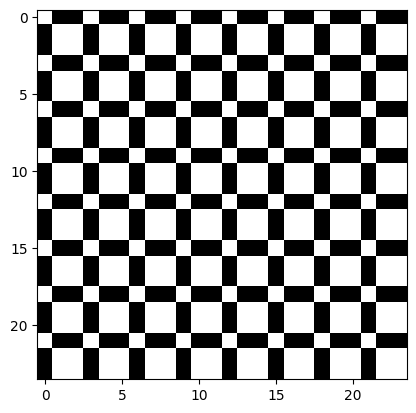

In [9]:
chess = cv2.imread('chessboard.bmp', cv2.IMREAD_GRAYSCALE)
chess_scaled = scale(chess, 1.5, 1.5)
plt.imshow(chess_scaled, 'gray')

## Interpolacja dwuliniowa

W praktyce, lepszym rozwiązaniem zwykle okazuje tzw. **interpolacja dwuliniowa** (ang. _bilinear interpolation_).
Wykorzystuje ona informację o czterech najbliższych sąsiadach do określenia nowej wartości piksela.

Jeśli przez $(i,j)$ oznaczymy współrzędne poszukiwanego piksela, a przez $I(i,j)$ jego jasność (składową w odcieniach szarości) to jego wartość można obliczyć wykorzystując równanie:
\begin{equation}
I(i,j) = a \cdot i + b \cdot j+ c \cdot i \cdot j + d
\end{equation}
gdzie: współczynniki $a,b,c,d$ można wyliczyć na podstawie czterech najbliższych sąsiadów.

![Ilustracja dwuliniowej](https://raw.githubusercontent.com/vision-agh/poc_sw/master/05_Resolution/img/interABCD.png)

Prześledźmy to na przykładzie z powyższego rysunku.
Niech współrzędne poszczególnych punktów to $A = (j_1,i_1)$, $B = (j_1,i_2)$, $ C= (j_2,i_2)$ oraz $D = (j_2,i_1)$.
W pierwszej kolejności dokonujemy interpolacji wartości w punktach $AB$ i $CD$ -- czyli poziomo.
Wychodząc od równania prostej otrzymujemy:

\begin{equation}
f(AB) \approx \frac{i_2 - i}{i_2-i_1}f(A) + \frac{i - i_1}{i_2-i_1}f(B)
\end{equation}

\begin{equation}
f(CD) \approx \frac{i_2 - i}{i_2-i_1}f(D) + \frac{i - i_1}{i_2-i_1}f(C)
\end{equation}

Następnie wykonujemy analogiczną interpolację w pionie:
\begin{equation}
f(ABCD) \approx \frac{j_2 - j}{j_2-j_1}f(AB) + \frac{j - j_1}{j_2-j_1}f(CD)
\end{equation}

Łącząc powyższe równania otrzymujemy:
\begin{equation}
f(ABCD) \approx \frac{1}{(i_2 - i_1)(j_2-j_1)} ( f(A)(i_2-i)(j_2 - y) + f(B)(i-i_1)(j_2 - j) \\ + f(C)(i-i_1)(j-j_1) + f(D)(i_2-i)(j-j_1))
\end{equation}
gdzie zapis $f(X)$ oznacza wartość piksela w punkcie $X$.

Rozważania można uprościć przyjmując, że narożniki rozpatrywanego kwadratu mają następujące współrzędne: $A = (0,0)$, $B = (0,1)$, $ C= (1,1)$ oraz $D = (1,0)$.
Wtedy powyższe równanie można zapisać:
\begin{equation}
f(ABCD) \approx f(A)(1-i)(1-j) + f(B)i(1-j) + f(C)ij + f(D)(1-i)j
\end{equation}

lub macierzowo:
\begin{equation}
f(ABCD) \approx \begin{bmatrix}1 - i & i \end{bmatrix} \begin{bmatrix} f(A) & f(D) \\\\ f(B) & f(C) \end{bmatrix} \begin{bmatrix} 1-j \\\\ j \end{bmatrix}
\end{equation}

Uwaga.
Nieco wbrew nazwie interpolacja dwuliniowa nie jest operacją liniową.
W złożeniu dwóch operacji liniowych pojawia się człon $xy$.

Warto dodać, że kolejny ``poziom wtajemniczenia'' to **interpolacja dwusześcienna** (ang. _bicubic interpolation_).
Dana jest ona wzorem:
\begin{equation}
I(i,j) = \sum*{i=0}^{3} \sum*{j=0}^{3} a\_{ij} x^i y^j
\end{equation}
Jej implementacja stanowi zadanie domowe do bieżącego ćwiczenia.

Trzy powyżej przedstawione metody bynajmniej nie wyczerpują tematu.
Wystarczy choćby otworzyć stronę [wiki o skalowaniu](https://en.wikipedia.org/wiki/Image_scaling), by zobaczyć, że metod jest dużo więcej.


Wykorzystując powyższe równania zaimplementuj interpolację dwuliniową:

- dobrym punktem wyjścia będzie stworzona funkcja do interpolacji metodą najbliższego sąsiada,
- początek powinien być identyczny,
- różnice rozpoczynają się w momencie obliczenia współrzędnych nowego piksela,
- jeśli chcemy zastosować opisane powyżej wzory (w wariancie uproszczonym), to musimy wyliczyć współrzędne punktów $A,B,C,D$,
- w pierwszym kroku obliczamy współrzędne $A$ tj. $(0,0)$ - należy do tego wykorzystać funkcję _floor_ (np. $i_1 = floor(i / h_{scale})$).
  Proszę ten krok odnieść do przedstawionego rysunku poglądowego,
- obliczenie współrzędnych $B,C,D$ jest już proste i sprowadza się do operacji `+1`,
- potrzebujemy jeszcze część ułamkową współrzędnych punktu $ABCD$ tj. $(i,j)$ - od ilorazu $i/h_{scale}$ należy odjąć wartość $i_1$
- wykorzystując wyznaczone współrzędne, należy pobrać wartości jasności w punktach $A,B,C,D$, tj. $f(A),f(B),f(C),f(D)$, podstawić do odpowiedniego równania i wykonać interpolację.

  Uwagi:

- Tworzenie macierzy _np.array_, mnożenie macierzy _np.dot_. Przy tworzeniu macierzy proszę zwrócić uwagę na niezbędne nawiasy kwadratowe.
- Przy próbie uruchomienia kodu pewnie okaże się, że wystąpi przekroczenie zakresu - należy dodać stosowne zabezpiczenie.

Proszę dla interpolacji dwuliniowej wykonać takie same eksperymenty, jak dla najbliższego sąsiada.


In [10]:
def two_line_interpolate(img, x_scale, y_scale):
    x, y = img.shape
    new_x = int(x * x_scale)
    new_y = int(y * y_scale)

    scaled_img = np.zeros((new_x, new_y), dtype=np.uint8)
    for xi in range(new_x):
        for yi in range(new_y):
            A_xi = int(xi / x_scale)
            A_yi = int(yi / y_scale)

            B_hx = min(A_xi, x-1)
            B_wx = min(A_yi + 1, y-1)

            C_hx = min(A_xi + 1, x-1)
            C_wx = min(A_yi + 1, y-1)

            D_hx = min(A_xi + 1, x-1)
            D_wx = min(A_yi, y-1)

            ratio_h = xi / x_scale - A_xi
            ratio_w = yi / y_scale - A_yi

            scaled_img[xi, yi] = int(np.array([[1 - ratio_h, ratio_h]])
                                     @ np.array([[img[A_xi, A_yi], img[B_hx, B_wx]],
                                                 [img[D_hx, D_wx], img[C_hx, C_wx]]])
                                     @ np.array([[1 - ratio_w], [ratio_w]]))
    return scaled_img

/var/folders/q7/yg89752j67l3h4xc96rw5y8h0000gn/T/ipykernel_4232/1861999441.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  scaled_img[xi, yi] = int(np.array([[1 - ratio_h, ratio_h]])


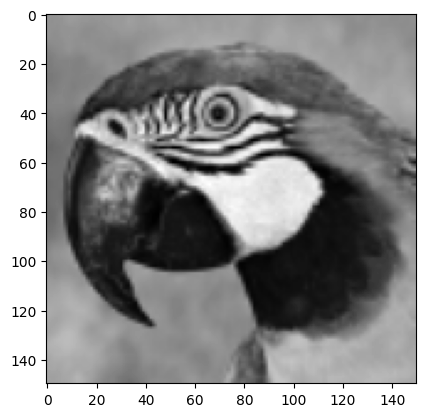

In [11]:
parrot_scaled = two_line_interpolate(parrot, 1.5, 1.5)
plt.imshow(parrot_scaled, 'gray')

## Intepolacja w OpenCV

W OpenCV dostępna jest funkcja `resize`, która służy do zmiany rozmiaru obrazka.
Składnia jest następująca `dst = cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]] )`, gdzie `dst` to obraz wynikowy, `src` obraz źródłowy, `dsize` rozmiar docelowy (ew. można podać współczynniki skalowania dla poszczególnych osi: `fx,fy`), `interpolation` metoda interpolacji.
Metod podstawowych dostępnych jest 5:

- najbliższego sąsiada - ` cv2.INTER_NEAREST`,
- dwuliniowa - ` cv2.INTER_LINEAR`,
- dwukubiczna - ` cv2.INTER_CUBIC`,
- _area_ - ` cv2.INTER_AREA`,
- _lanczos4_ - ` cv2.INTER_LANCZOS4`.

Przeprowadzimy następujący eksperyment: obraz (o większej niż dotąd rozdzielczości) przeskalujemy każdą z metod -- zwiększymy i zmniejszymy jego rozdzielczość. Dodamy też pomiar czasu realizacji obliczeń.

Proszę stworzyć funkcję, która jako argumenty przyjmuje obraz oraz dwa współczynniki skalujące, a wewnątrz przeprowadzone zostaną interpolacje, pomiar czasu oraz wizualizacja (można wypisać czas w tytule rysunku).

Pomiar czasu:

```{python}
from timeit import default_timer as timer
start = timer()
# ...
end = timer()
print(end - start)
```

Wykonaj eksperyment dla kilku różnych skal, przeanalizuj czasy obliczeń.


In [12]:
from timeit import default_timer as timer


def measure_times(img, scale_up, scale_down):
    def new_size(shape, scale):
        shape = np.array(shape) * scale
        shape = shape.astype(int)
        return shape

    flags = [cv2.INTER_NEAREST, cv2.INTER_LINEAR,
             cv2.INTER_CUBIC, cv2.INTER_AREA, cv2.INTER_LANCZOS4]
    fig, ax = plt.subplots(1, len(flags))
    fig.set_size_inches(30, 30)

    for i, flag in enumerate(flags):
        times = []
        for _ in range(1000):
            start = timer()
            img_scaled = cv2.resize(img, new_size(
                img.shape, scale_up), interpolation=flag)
            img_scaled = cv2.resize(img_scaled, new_size(
                img_scaled.shape, scale_down), interpolation=flag)
            end = timer()
            times.append(end-start)

        ax[i].imshow(img_scaled, 'gray', vmin=0, vmax=256)
        ax[i].axis('off')
        ax[i].set_title(np.mean(times))

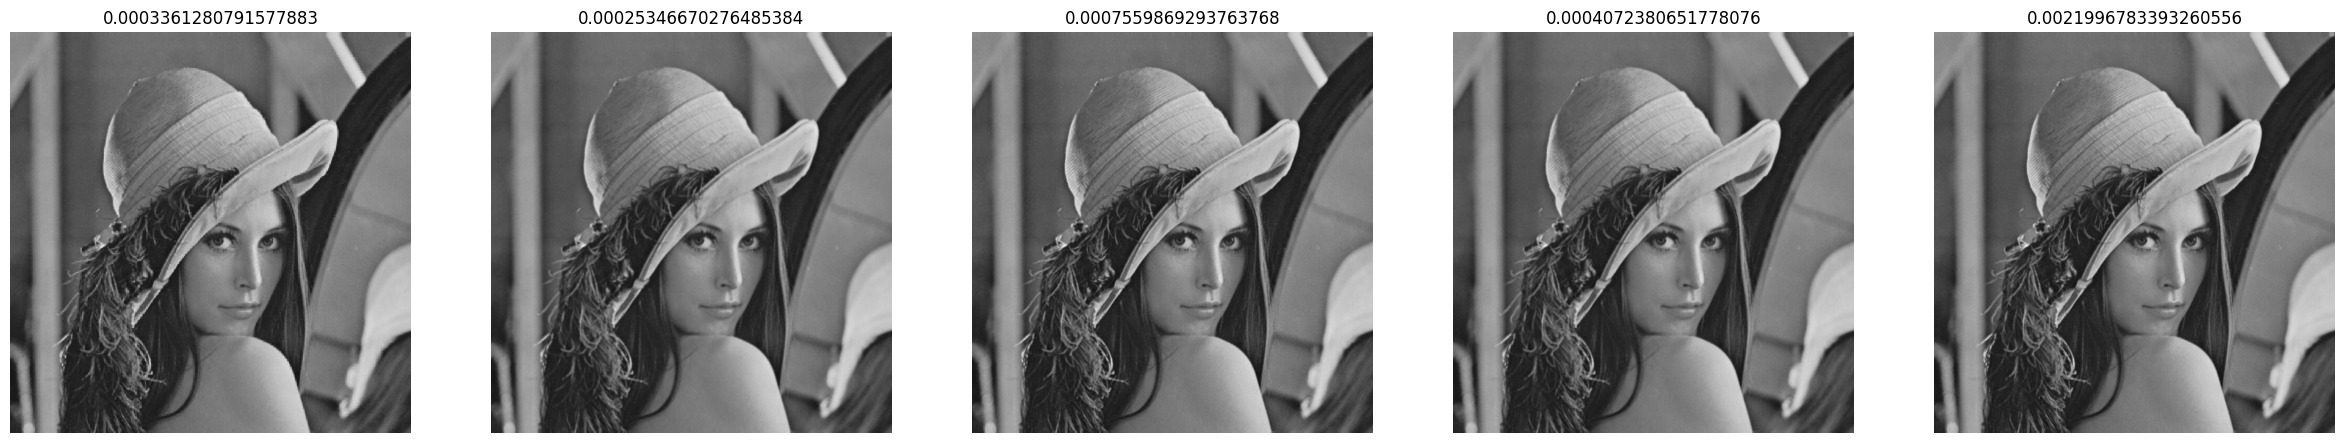

In [13]:
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
measure_times(lena, 1.5, 1.2)

## Rozdzielczość (dpi)

Omówioną wcześniej rozdzielczość przestrzenną (rozmiar) należy utożsamiać z rozmiarem macierzy w której zapisany jest obraz.
W tym ujęciu rozmiar pojedynczego piksela nie ma specjalnego znaczenia.
Problem pojawia się, kiedy obraz trzeba wyświetlić lub wydrukować.
Wtedy pojedynczy piksel staje się ,,obiektem fizycznym'' i musi mieć swój rozmiar (wysokość/szerokość/powierzchnię).

Parametr dpi (ang. _dots per inch_) określa liczbę kropek (pikseli), która mieści się na jednym calu (25,4 mm) długości/szerokości.
Dopiero kombinacja rozmiaru i rozdzielczości określa nam rzeczywisty rozmiar obrazu jaki uzyskamy na wydruku.

Dpi staje się istotne w przypadku drukowania, gdyż wyświetlanie na monitorze odbywa się zazwyczaj 1 piksel obrazka = 1 piksel na monitorze (w przypadku maksymalnej rozdzielczości wspieranej przez monitor), ew. następuje automatyczne skalowanie.

Wpływ rozdzielczości można zademonstrować w następujący sposób:

- wczytaj obraz _lena.bmp_. Ma on rozmiar $512 \times 512$.
- wykorzystując funkcję `imresize` stwórz obrazy o rozmiarach $256 \times 256$, $128 \times 128$, $64 \times 64$ - metoda interpolacji jest w tym wypadku mniej istotna.
- wyświetl obrazy wymuszając zachowanie na ekranie wejściowej rozdzielczości $512 \times 512$. W przypadku biblioteki _matplotlib_ ta funkcjonalność jest domyślna.

Proszę zaobserwować co dzieję się z obrazkiem.


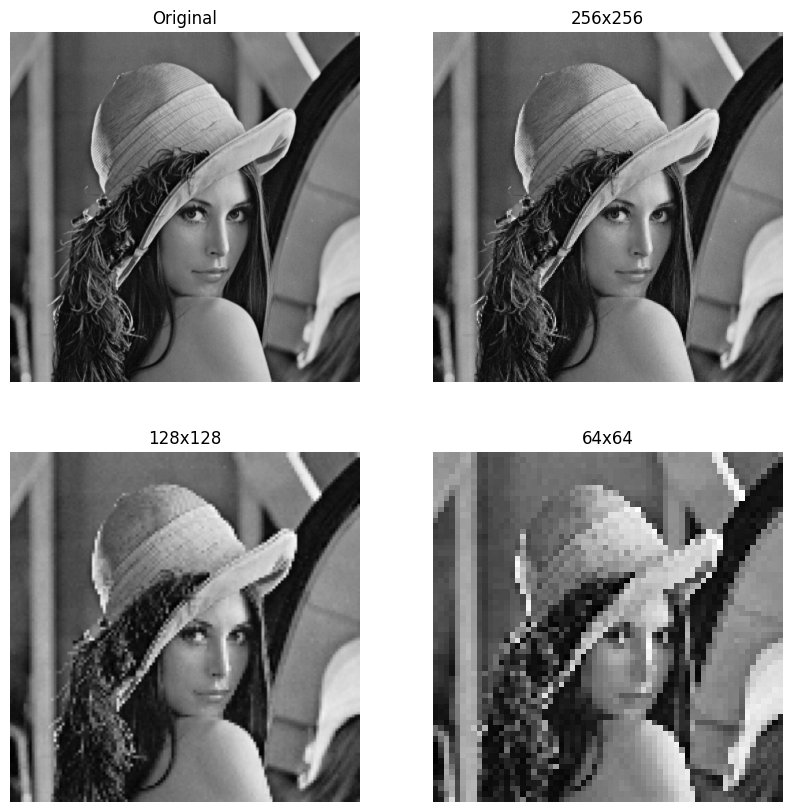

In [14]:
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
lena_256 = cv2.resize(lena, (256, 256), interpolation=cv2.INTER_NEAREST)
lena_128 = cv2.resize(lena_256, (128, 128), interpolation=cv2.INTER_NEAREST)
lena_64 = cv2.resize(lena_128, (64, 64), interpolation=cv2.INTER_NEAREST)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
ax[0, 0].imshow(lena, 'gray')
ax[0, 0].axis('off')
ax[0, 0].set_title('Original')
ax[0, 1].imshow(lena_256, 'gray')
ax[0, 1].axis('off')
ax[0, 1].set_title('256x256')
ax[1, 0].imshow(lena_128, 'gray')
ax[1, 0].axis('off')
ax[1, 0].set_title('128x128')
ax[1, 1].imshow(lena_64, 'gray')
ax[1, 1].axis('off')
ax[1, 1].set_title('64x64')
plt.show()

## Liczba poziomów jasności

Dla obrazów w skali szarości pojedynczy piksel zwykle zapisuje się na 8 bitach, co daje 256 rozróżnialnych poziomów szarości.
Dla większości zastosowań wartość ta jest wystarczająca (choć są kamery o wyjścu 12 lub 16 bitów).
Jednak oko ludzkie nie potrafi rozróżnić wszystkich 256 poziomów jasności (jest za mało czułe).
Zazwyczaj człowiek rozróżnia 20-30 poziomów szarości (to ile i jakie dokładnie rozróżnia, zależy od konkretnego oświetlenia sceny i cech osobniczych).

W poniższych krokach zademonstrujemy omówione zjawisko:

- wczytaj (użyj) obrazu _lena_,
- wykorzystując znaną funkcję `normalize` zmień liczbę poziomów szarości z 0-255 na:
  - 0-31
  - 0-15
  - 0-7
  - 0-3
  - 0-1 (binaryzacja)
- rezultaty wyświetl na wspólnym rysunku.

Podpowiedzi:

- trzeba przygotować tablice na obrazki np, `I_31 = np.zeros(I.shape,'uint8')`,
- prawidłowe użycie funkcji normalize `cv2.normalize(I,I_31,0,31,cv2.NORM_MINMAX)`,
- przykładowe wyświetlanie `axsHist[0,1].imshow(I, 'gray', vmin=0, vmax=31)`.

Czy rezultaty eksperymentu pasują do teorii o rozpoznawaniu przez człowieka ograniczonego zakresu poziomów jasności?
Wizualne porównanie których obrazów o tym świadczy?


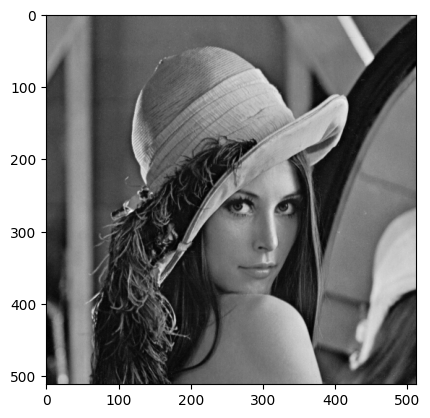

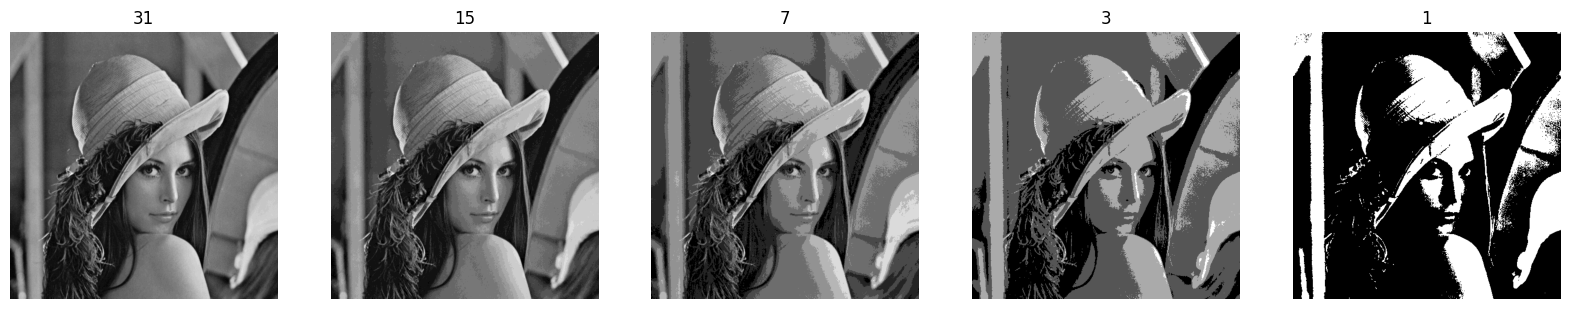

In [15]:
I = cv2.imread('lena.bmp')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
normalize_to = [31, 15, 7, 3, 1]

normalized = [cv2.normalize(I, None, alpha=0, beta=norm, norm_type=cv2.NORM_MINMAX)
              for norm in normalize_to]

plt.imshow(I, 'gray')
fig, ax = plt.subplots(1, len(normalized))
fig.set_size_inches(20, 20)

for i, (img, norm) in enumerate(zip(normalized, normalize_to)):
    ax[i].imshow(img, 'gray', vmin=0, vmax=norm)
    ax[i].axis('off')
    ax[i].set_title(norm)